In [1]:
# https://github.com/matterport/Mask_RCNN    
import cv2
import argparse
import numpy as np
import os.path
import sys
import random

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

In [8]:
# Draw the predicted bounding box, colorize and show the mask on the image

def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold) # class
    roi = frame[top:bottom+1, left:right+1][mask]

    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]                 # mask 가중치    
    frame[top:bottom+1, left:right+1][mask] = ([0.7*color[0], 0.7*color[1], 0.7*color[2]] + 
                                               0.3 * roi).astype(np.uint8)  # 계수의 합이 1이 되어야 픽셀값이 255까지 오기 때문

    
def postprocess(boxes, masks):
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]  # 7개 정보  ?, classid, score, left, top 
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            # 아래코드들은 박스가 영상보다 클때 영상안에서 박스를 제한하려고 재설정한 코드
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)



In [4]:
classesFile = "mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
   classes = f.read().rstrip('\n').split('\n')

print(classes)
print('\n')

textGraph = "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "frozen_inference_graph.pb"   # 다운받아야 함

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)
print(colors)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


[array([  0., 255.,   0.]), array([  0.,   0., 255.]), array([255.,   0.,   0.]), array([  0., 2

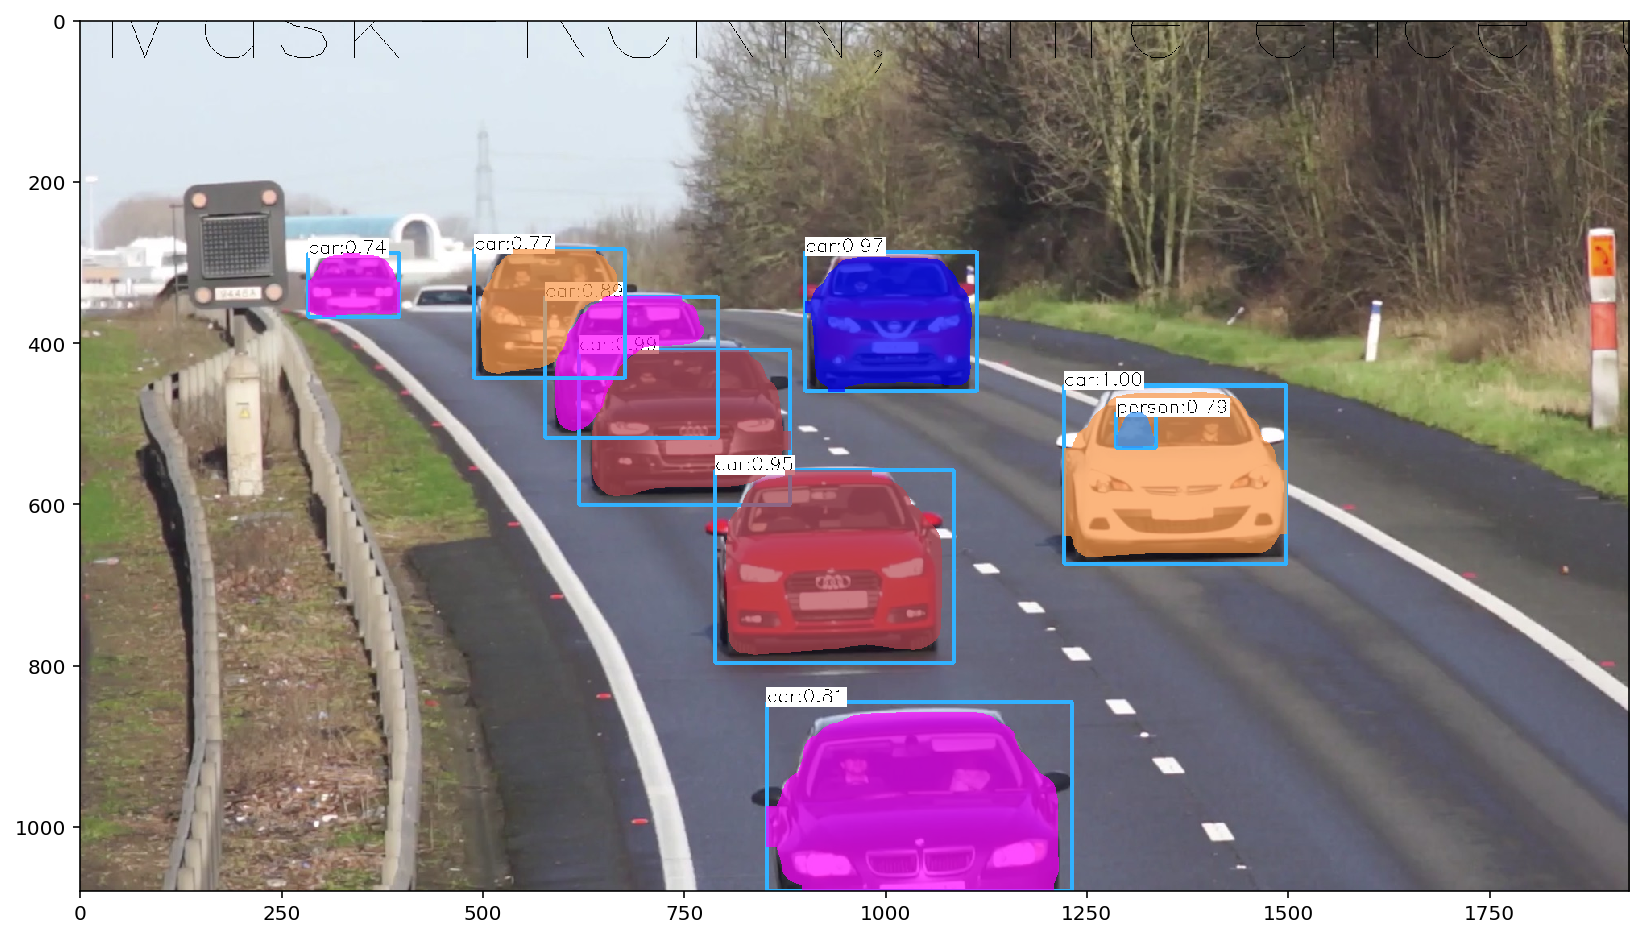

In [5]:
frame = cv2.imread('../2020.01.29/cars.jpg')

blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
net.setInput(blob)

boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

postprocess(boxes, masks)

t, _ = net.getPerfProfile()
label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0))

cv2.imwrite("output.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(15,8))
plt.imshow(img)
plt.show()

(1, 1, 100, 7)
(100, 90, 15, 15)
[0.         2.         0.81254685 0.44311842 0.78289765 0.64019954
 1.        ]
2


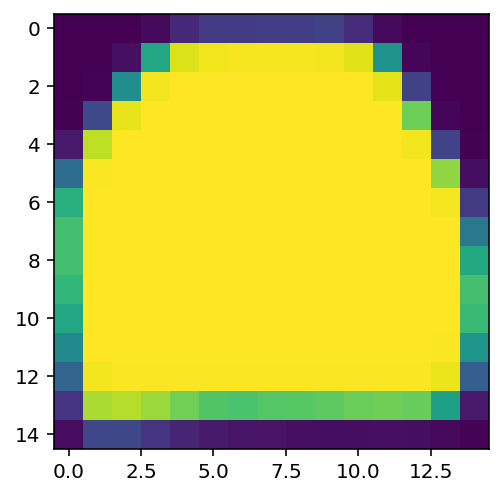

In [6]:
print(boxes.shape)   # 1,1,100box,7개 정보
print(masks.shape)   # 100개box, 90개클래스, mask size

print(boxes[0,0,5])  # 5번째 box
id = int(boxes[0,0,5,1])
print(id)

m = masks[0,id, :,:]
plt.imshow(m)

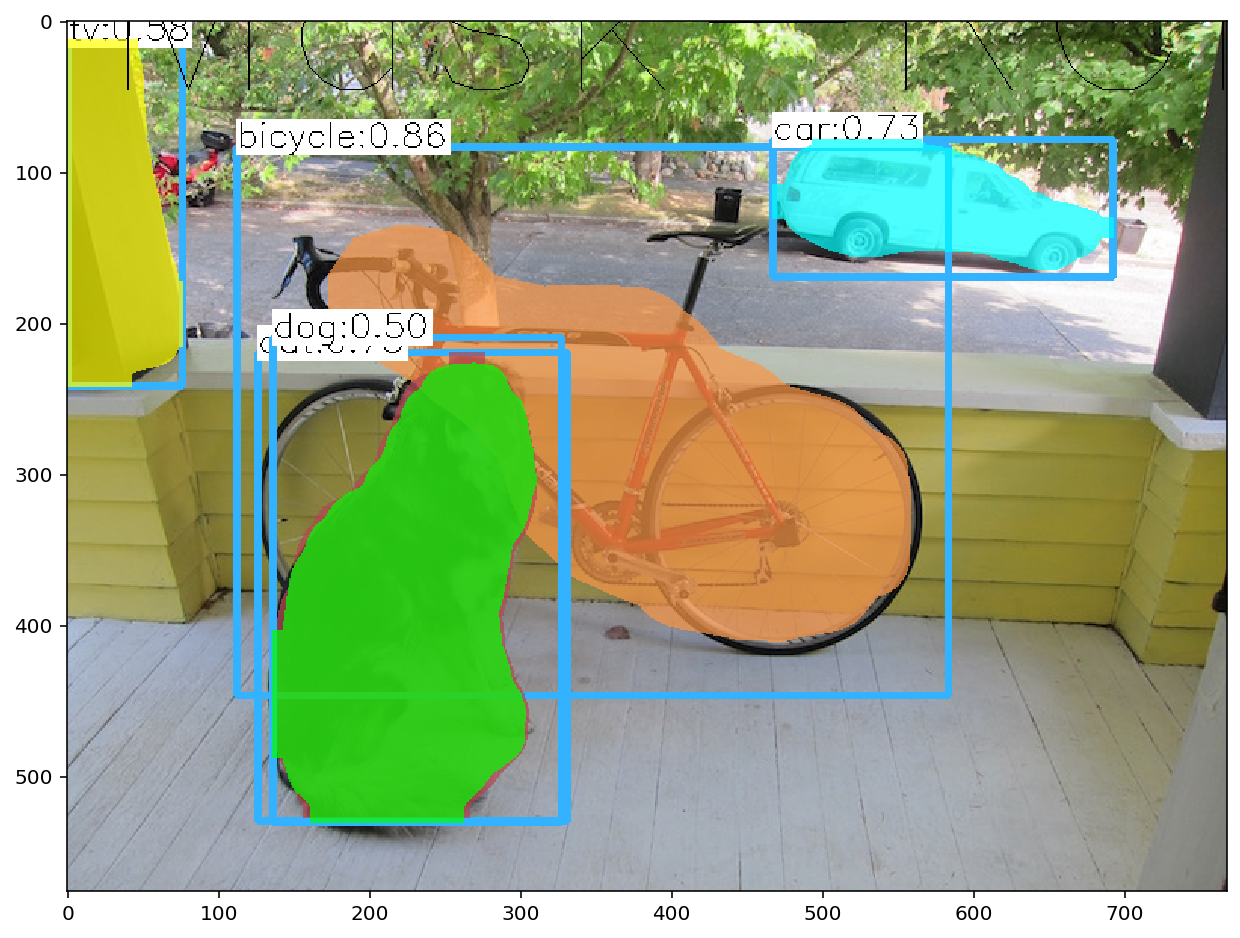

(1, 1, 100, 7)
(100, 90, 15, 15)
[0.         7.         0.42450282 0.6093582  0.12880099 0.90505886
 0.2896334 ]
7


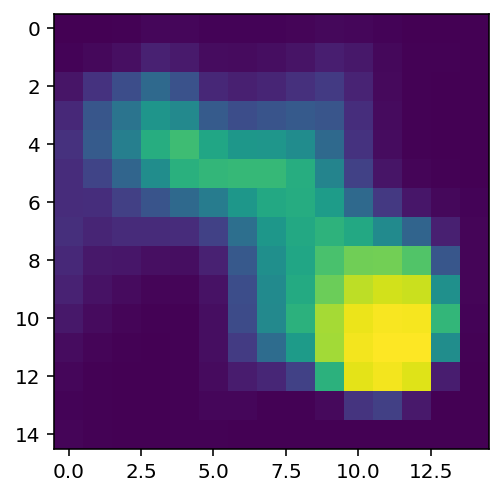

In [7]:
frame = cv2.imread('../2020.01.28/dog2.jpg')

blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
net.setInput(blob)

boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

postprocess(boxes, masks)

t, _ = net.getPerfProfile()
label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0))

cv2.imwrite("output.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig=plt.figure(figsize=(15,8))
plt.imshow(img)
plt.show()

print(boxes.shape)   # 1,1,100box,7개 정보
print(masks.shape)   # 100개box, 90개클래스, mask

print(boxes[0,0,5])  # 5번째 box
id = int(boxes[0,0,5,1])
print(id)

m = masks[0,id, :,:]
plt.imshow(m)